In [441]:
import os
import cv2
import glob
import math
import shutil
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [442]:
def extract_zip(file_path, extract_to):
    """
    Extracts the contents of a zip file to a specified directory.
    """
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Files extracted to {extract_to}')

In [443]:
def extract_data_from_sheet(df):
    """
    Extracts and formats data from a given DataFrame representing an Excel sheet.
    """
    sensor_name = df.iloc[0, 1]
    extracted_df = df.iloc[3:].reset_index(drop=True)
    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')
    extracted_df['Sensor Info'] = sensor_name
    return extracted_df

In [444]:
def split_sensor_info(sensor_info):
    """
    Splits the sensor info to extract the sensor ID and sensor name.
    """
    parts = sensor_info.split(' ')
    return pd.Series([parts[0], sensor_info])

In [445]:
def read_all_excel_files(directory):
    """
    Reads and consolidates data from all Excel files in the extraction directory.
    """
    data_frames = []
    excel_files = glob.glob(os.path.join(directory, '**', '*.*'), recursive=True)
    
    for excel_file in excel_files:
        try:
            # Determine the file extension and read the file accordingly
            if excel_file.endswith('.xlsx'):
                xls = pd.ExcelFile(excel_file, engine='openpyxl')
            elif excel_file.endswith('.xls'):
                xls = pd.ExcelFile(excel_file, engine='xlrd')
            else:
                print(f'Skipping non-Excel file: {excel_file}')
                continue
            
            for sheet_name in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet_name)
                extracted_df = extract_data_from_sheet(df)
                data_frames.append(extracted_df)
        
        except Exception as e:
            print(f'Error reading {excel_file}: {e}')
            continue
    
    # Combine all data frames into a single DataFrame
    if data_frames:
        combined_data = pd.concat(data_frames, ignore_index=True)
    
        # Perform operations on combined_data
        combined_data[['Sensor ID', 'Sensor Name']] = combined_data['Sensor Info'].apply(split_sensor_info)
        combined_data = combined_data.drop('Sensor Info', axis=1)
    else:
        combined_data = pd.DataFrame(columns=['Time', 'Temperature', 'Humidity', 'Sensor ID', 'Sensor Name'])
    
    return combined_data

In [446]:
def sort_data(data, keys_list):
    """
    Sorts the DataFrame based on the sensor ID in the given order.
    """
    data['Sensor ID'] = pd.Categorical(data['Sensor ID'], categories=keys_list, ordered=True)
    df_sorted = data.sort_values(by='Sensor ID')
    df_sorted = df_sorted[~pd.isna(df_sorted['Sensor ID'])]
    df_sorted['Sensor ID'] = df_sorted['Sensor ID'].astype(str)
    df_sorted.reset_index(drop=True, inplace=True)
    return df_sorted

In [447]:
def generate_heatmap_frames(sample_dataset, output_dir, sensor_order_dict):
    """
    Generates heatmap frames from the dataset and saves them as images in the specified directory.
    """
    sample_dataset['Humidity'] = sample_dataset['Humidity'].astype(float)

    num_sensors = len(sample_dataset['Sensor ID'].unique())
    range_values = min(20, math.ceil(len(sample_dataset) / num_sensors))  # Ensure we only generate up to 20 frames

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    os.makedirs(output_dir)

    frames = []
    for i in range(1, range_values + 1):
        temp_dataset = sample_dataset.groupby('Sensor ID').nth(-i).reset_index()
        
        # Create an 8x7 matrix for humidity values
        heat_map_data = np.full((8, 7), np.nan)

        for idx, row in temp_dataset.iterrows():
            sensor_id = row['Sensor ID']
            humidity = row['Humidity']
            if sensor_id in sensor_order_dict:
                position = sensor_order_dict[sensor_id]
                row_idx, col_idx = position[0] - 1, position[1] - 1  # Convert to 0-based index
                heat_map_data[row_idx, col_idx] = humidity

        plt.figure(figsize=(10, 8))
        sns.heatmap(heat_map_data, annot=False, cmap="magma", cbar=True, 
                    xticklabels=[f'Col {j+1}' for j in range(7)], 
                    yticklabels=[f'Row {j+1}' for j in range(8)])
        plt.title(f'Humidity Heat Map for Data Point {20 - i} from Last')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        output_file = os.path.join(output_dir, f"heatmap_{i}.png")
        plt.savefig(output_file)
        plt.close()

        frames.append(output_file)

    return frames

In [448]:
def generate_video_from_frames(frames, video_output):
    """
    Generates a video from a list of image frames and saves it as an MP4 file.
    """
    if not frames:
        print("No frames to generate video.")
        return
    
    frame = cv2.imread(frames[0])
    height, width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    video = cv2.VideoWriter(video_output, fourcc, 5.0, (width, height))

    prev_frame = cv2.imread(frames[0])

    for frame_path in frames[1:]:
        next_frame = cv2.imread(frame_path)
        
        for i in range(1, 10):
            alpha = i / 10.0
            interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
            video.write(interpolated_frame)

        prev_frame = next_frame

    video.release()
    cv2.destroyAllWindows()

    print(f"Video saved as: {video_output}")

In [449]:
def generate_sequences(series, step_size):
    """
    Generate sequences of data for supervised learning.
    """
    input_sequences, target_values = [], []
    for idx in range(step_size, len(series)):
        sequence = series[idx-step_size:idx]
        if not np.isnan(series[idx]) and not np.isnan(sequence).any():
            input_sequences.append(sequence)
            target_values.append(series[idx])
    return np.array(input_sequences), np.array(target_values)

def create_model():
    """
    Create and return a Linear Regression model.
    """
    return LinearRegression()

In [450]:
def impute_missing_values(df, trained_model, column_name, step_size):
    """
    Impute missing values in the dataset using the trained model.
    """
    df_copy = df.copy()
    column_data = df_copy[column_name].astype(float).values
    for idx in range(step_size, len(column_data)):
        if np.isnan(column_data[idx]):
            input_data = column_data[idx-step_size:idx]
            if np.isnan(input_data).any():
                continue
            input_data = input_data.reshape(1, -1)
            predicted_value = trained_model.predict(input_data)
            column_data[idx] = np.round(predicted_value.item(), 2)
    df_copy[column_name] = column_data
    return df_copy

In [451]:
def process_and_impute(df, column_name, step_size):
    """
    Train the model on the existing data and impute missing values.
    """
    column_data = df[column_name].astype(float).values
    inputs, targets = generate_sequences(column_data, step_size)
    if len(inputs) == 0 or len(targets) == 0:
        print("Insufficient data to train the model.")
        return df
    
    model = create_model()
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    filled_df = impute_missing_values(df, model, column_name, step_size)
    return filled_df

In [452]:
# Check for null values in the dataset
def check_null_values(df):
    null_summary = df.isnull().sum()
    total_nulls = null_summary.sum()
    return null_summary, total_nulls

In [453]:
# Define the file paths
zip_file_path = 'Data17052024-210552024-1.zip'
extraction_path = 'extracted_files'
sensor_order = [
    "047D6", "0475D", "0479B", "047BB", "04754", "047CE", "047CB",
    "0474D", "04757", "047AA", "047C2", "047F7", "04756", "047C1",
    "0478A", "04762", "04768", "04789", "04773", "047B7", "047D3",
    "047B8", "04750", "0480E", "047DD", "047D7", "047A8", "047BA",
    "047B2", "04804", "04763", "047B6", "047C4", "047D2", "04765",
    "047C8", "0477F", "0478C", "047D4", "0479E", "047C9", "047C7",
    "047CA", "0476E", "0478E", "0475C", "04787", "047AD", "047BC",
    "0475A", "04771", "04791", "04802", "047C5", "04796", "047CD"
]

# Extract zip file
extract_zip(zip_file_path, extraction_path)

# Read all Excel files from the extracted directory
combined_data = read_all_excel_files(extraction_path)
print(f"Combined data shape: {combined_data.shape}")

# Sort the data according to sensor order
sorted_data = sort_data(combined_data, sensor_order)
print(f"Sorted data shape: {sorted_data.shape}")

# Save the sorted data to a new Excel file
sorted_output_file = 'Organized_data.xlsx'
sorted_data.to_excel(sorted_output_file, index=False)
print(f"Sorted data saved to {sorted_output_file}")

Files extracted to extracted_files
Combined data shape: (588879, 5)
Sorted data shape: (588254, 5)
Sorted data saved to Organized_data.xlsx


In [454]:
sorted_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-10 03:41:57,10.85,83.2,047D6,047D6 T/RH IP67
1,2024-05-02 06:09:22,12.9,94.3,047D6,047D6 T/RH IP67
2,2024-05-02 06:14:20,13.3,93.2,047D6,047D6 T/RH IP67
3,2024-05-02 06:19:20,13.55,93.1,047D6,047D6 T/RH IP67
4,2024-05-02 06:24:22,13.8,92,047D6,047D6 T/RH IP67


In [455]:
sorted_data.tail()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
588249,2024-04-27 22:10:19,11.15,86.9,047CD,047CD T/RH IP67
588250,2024-04-27 22:15:19,11.1,85,047CD,047CD T/RH IP67
588251,2024-04-27 22:20:18,10.9,83.8,047CD,047CD T/RH IP67
588252,2024-04-27 21:45:21,11.4,86.6,047CD,047CD T/RH IP67
588253,2024-05-20 15:41:47,30.5,38.9,047CD,047CD T/RH IP67


In [456]:
# Define the sensor order for 8x7 matrix
sensor_order_matrix = [
    ["047D6", "0475D", "0479B", "047BB", "04754", "047CE", "047CB"],
    ["0474D", "04757", "047AA", "047C2", "047F7", "04756", "047C1"],
    ["0478A", "04762", "04768", "04789", "04773", "047B7", "047D3"],
    ["047B8", "04750", "0480E", "047DD", "047D7", "047A8", "047BA"],
    ["047B2", "04804", "04763", "047B6", "047C4", "047D2", "04765"],
    ["047C8", "0477F", "0478C", "047D4", "0479E", "047C9", "047C7"],
    ["047CA", "0476E", "0478E", "0475C", "04787", "047AD", "047BC"],
    ["0475A", "04771", "04791", "04802", "047C5", "04796", "047CD"]
]

# Create a dictionary from the sensor order matrix for quick lookup
sensor_order_dict = {sensor: (row_idx + 1, col_idx + 1)
                     for row_idx, row in enumerate(sensor_order_matrix)
                     for col_idx, sensor in enumerate(row)}

# Define the file paths
heatmap_dir = 'New_heatmaps'
video_output_path = 'Humidity_Heatmap_video.mp4'

# Generate frames for humidity
frames = generate_heatmap_frames(sorted_data, heatmap_dir, sensor_order_dict)

# Generate video from the frames
generate_video_from_frames(frames, video_output_path)

print(f"Humidity heat maps saved to {heatmap_dir}")

Video saved as: Humidity_Heatmap_video.mp4
Humidity heat maps saved to New_heatmaps


In [457]:
# Usage with sorted_data
null_summary, total_nulls = check_null_values(sorted_data)

print("Null values in each column:\n", null_summary)
print(f"\nTotal null values in the dataset: {total_nulls}")

Null values in each column:
 Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

Total null values in the dataset: 18702


In [458]:
# Fill missing values for 'Temperature'
filled_df = process_and_impute(combined_data, 'Temperature', step_size=5)
print(filled_df.head())

                 Time  Temperature Humidity Sensor ID      Sensor Name
0 2024-04-16 13:05:51        22.80     76.4     0478E  0478E T/RH IP67
1 2024-04-16 13:10:50        23.25     35.3     0478E  0478E T/RH IP67
2 2024-04-16 13:15:48        24.30     39.3     0478E  0478E T/RH IP67
3 2024-04-16 13:20:49        25.20     30.3     0478E  0478E T/RH IP67
4 2024-04-16 13:25:50        24.65     31.5     0478E  0478E T/RH IP67


In [459]:
# Fill missing values for 'Humidity'
filled_df = process_and_impute(filled_df, 'Humidity', step_size=5)

In [460]:
# Ensure sorted_data is sorted according to the sensor order before saving
filled_data_sorted = sort_data(filled_df, sensor_order)

# Save the filled and sorted data to a new Excel file
filled_output_file = 'Imputed_data.xlsx'
filled_data_sorted.to_excel(filled_output_file, index=False)

print(f"Filled and sorted data saved to {filled_output_file}")

Filled and sorted data saved to Imputed_data.xlsx


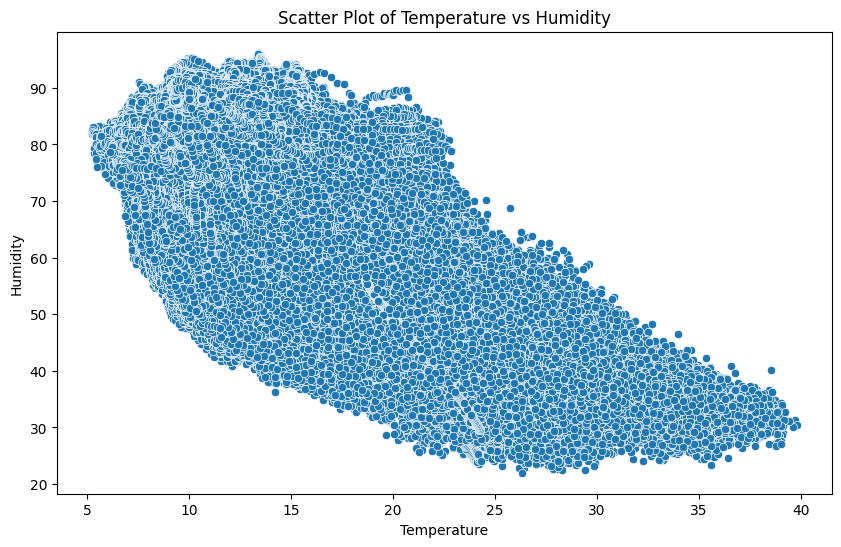

In [461]:
# Filter data to ensure no NaNs in the columns of interest
df_filtered = filled_data_sorted[['Temperature', 'Humidity']].dropna()

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Humidity', data=df_filtered)
plt.title('Scatter Plot of Temperature vs Humidity')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

In [462]:
filled_data_sorted.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-10 03:41:57,10.85,83.2,047D6,047D6 T/RH IP67
1,2024-05-02 06:09:22,12.90,94.3,047D6,047D6 T/RH IP67
2,2024-05-02 06:14:20,13.30,93.2,047D6,047D6 T/RH IP67
3,2024-05-02 06:19:20,13.55,93.1,047D6,047D6 T/RH IP67
4,2024-05-02 06:24:22,13.80,92.0,047D6,047D6 T/RH IP67


In [463]:
filled_data_sorted.tail()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
588249,2024-04-27 22:10:19,11.15,86.9,047CD,047CD T/RH IP67
588250,2024-04-27 22:15:19,11.10,85.0,047CD,047CD T/RH IP67
588251,2024-04-27 22:20:18,10.90,83.8,047CD,047CD T/RH IP67
588252,2024-04-27 21:45:21,11.40,86.6,047CD,047CD T/RH IP67
588253,2024-05-20 15:41:47,30.50,38.9,047CD,047CD T/RH IP67


In [464]:
# Checkinf for null values in the newly stored dataset

# Usage with filled and sorted data
null_summary, total_nulls = check_null_values(filled_data_sorted)

print("Null values in each column:\n", null_summary)
print(f"\nTotal null values in the dataset: {total_nulls}")

Null values in each column:
 Time           0
Temperature    0
Humidity       0
Sensor ID      0
Sensor Name    0
dtype: int64

Total null values in the dataset: 0


In [465]:
# Calculate the mean of the temperature and humidity values
mean_temperature = filled_data_sorted['Temperature'].mean()
mean_humidity = filled_data_sorted['Humidity'].mean()

mean_vector = [mean_temperature, mean_humidity]
print("Mean Vector:", mean_vector)

Mean Vector: [17.5739796414474, 66.20139448265545]


In [466]:
# Calculate the covariance matrix of the temperature and humidity values
covariance_matrix = filled_data_sorted[['Temperature', 'Humidity']].cov()
print("Covariance Matrix:\n", covariance_matrix)

Covariance Matrix:
              Temperature    Humidity
Temperature    48.668516 -102.423040
Humidity     -102.423040  311.320776


In [467]:
# # Assuming mean_vector and covariance_matrix are already defined
# mv_normal = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

# # Generate a grid of points to evaluate the distribution
# x_min, x_max = filled_data_sorted['Temperature'].min() - 5, filled_data_sorted['Temperature'].max() + 5
# y_min, y_max = filled_data_sorted['Humidity'].min() - 5, filled_data_sorted['Humidity'].max() + 5

# x, y = np.mgrid[x_min:x_max:0.3, y_min:y_max:0.3]
# pos = np.dstack((x, y))

# # Evaluate the multivariate normal distribution at each grid point
# z = mv_normal.pdf(pos)


# # Plotting the original data
# plt.figure(figsize=(10, 6))
# plt.scatter(filled_data_sorted['Temperature'], filled_data_sorted['Humidity'], alpha=0.5, label='Data')

# # Plotting the fitted Gaussian distribution
# plt.contour(x, y, z, levels=10, cmap='viridis', linewidths=1)
# plt.title('Fitted Multivariate Normal Distribution')
# plt.xlabel('Temperature')
# plt.ylabel('Humidity')
# plt.legend()
# plt.show()

In [468]:
def plot_gaussian_ellipses(gmm, ax):
    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        unit_eigenvector = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
        angle = np.arctan2(unit_eigenvector[1], unit_eigenvector[0])
        angle = np.degrees(angle)
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

        # Print mean and covariance for each Gaussian distribution
        print(f"Gaussian Component {i+1}:")
        print(f"Mean: {mean}")
        print(f"Covariance:\n{cov}\n")

In [469]:
data = filled_data_sorted[['Temperature', 'Humidity']].dropna().values

# Fit a GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)
labels = gmm.predict(data)

# Create a mesh grid for plotting
x = np.linspace(data[:, 0].min() - 1, data[:, 0].max() + 1, 100)
y = np.linspace(data[:, 1].min() - 1, data[:, 1].max() + 1, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

Gaussian Component 1:
Mean: [13.11918959 79.93826769]
Covariance:
[[12.55278887 -9.11585092]
 [-9.11585092 41.49584677]]

Gaussian Component 2:
Mean: [23.07389497 49.24175362]
Covariance:
[[ 38.50702827 -48.79213871]
 [-48.79213871 123.84550805]]



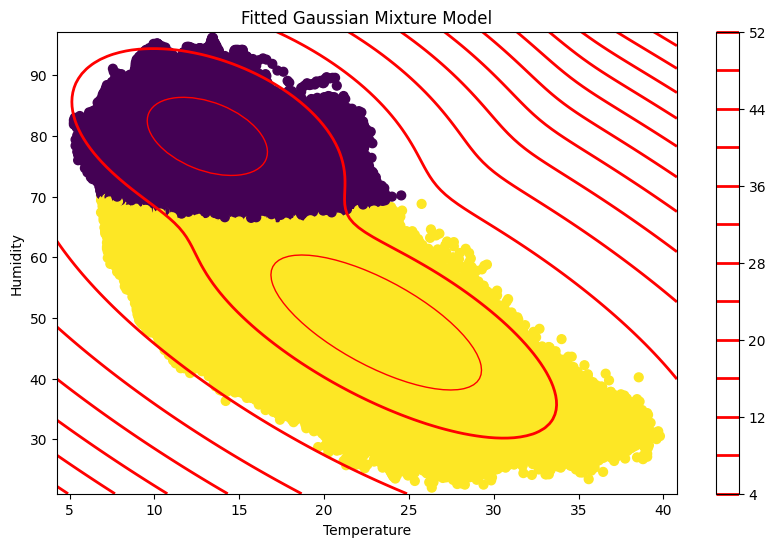

In [470]:
# Plot the results
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=40, marker='o')
plt.contour(X, Y, Z, levels=14, linewidths=2, colors='red')
plot_gaussian_ellipses(gmm, ax)
plt.colorbar()
plt.title('Fitted Gaussian Mixture Model')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

In [471]:
# # Determine the threshold for outliers (e.g., 5th percentile)
# threshold = np.percentile(gmm.score_samples(data), 5)
# print(f"Threshold for outliers: {threshold}")

# # Filter out the outliers
# filtered_data = filled_data_sorted[gmm.score_samples(data) > threshold]

# # Check the shape of the original and filtered data
# print(f"Original data shape: {filled_data_sorted.shape}")
# print(f"Filtered data shape: {filtered_data.shape}")

In [474]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'combined_data' is your DataFrame containing the sensor data.

# Group data by 'Sensor ID' and calculate mean temperature and humidity
grouped_data = filled_data_sorted.groupby('Sensor ID').agg({
    'Temperature': 'mean',
    'Humidity': 'mean'
}).reset_index()

# Prepare the features and targets
X = grouped_data[['Temperature', 'Humidity']]
y = grouped_data[['Temperature', 'Humidity']]  # In this example, targets are the same as features.

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define and train the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, activation='relu', solver='adam', learning_rate='adaptive', random_state=42)
mlp.fit(X_train, y_train)

# Predict using the trained model
predictions = mlp.predict(X_test)

# Evaluate the model
print("Model score:", mlp.score(X_test, y_test))

Model score: -40.01822795085259


/Users/abineshm/FinalDissertation/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
